<a href="https://colab.research.google.com/github/fazalpge/product_forecasting/blob/main/Multivariate_multiple_timeseries_forecasting_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
from prophet import Prophet
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [48]:
class ProphetModel(BaseEstimator, TransformerMixin):
    def __init__(self, periods=30, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=None):
        self.periods = periods
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.holidays = holidays
        self.models = {}

    def fit(self, X, y=None):
        # Extract unique combinations of 'Location' and 'ItemName'
        unique_combinations = X[['Location', 'ItemName']].drop_duplicates()
        for _, row in unique_combinations.iterrows():
            location = row['Location']
            item_name = row['ItemName']
            # Filter data for the current combination of 'Location' and 'ItemName'
            sub_df = X[(X['Location'] == location) & (X['ItemName'] == item_name)].copy()
            # Rename columns for Prophet
            sub_df = sub_df.rename(columns={'TransactionDate': 'ds', 'SaleAmount': 'y', 'SaleBonusQty': 'bonus_qty'})
            # Ensure the 'ds' column is in datetime format
            sub_df['ds'] = pd.to_datetime(sub_df['ds'], format='%Y-%m-%d')
            # Fill NaN values in 'bonus_qty' with 0 or any other suitable value
            sub_df['bonus_qty'] = sub_df['bonus_qty'].fillna(0)
            # Check if there are at least 2 non-NaN rows
            if sub_df.dropna().shape[0] >= 2:
                # Initialize and fit Prophet model
                model = Prophet(
                    yearly_seasonality=self.yearly_seasonality,
                    weekly_seasonality=self.weekly_seasonality,
                    daily_seasonality=self.daily_seasonality,
                    holidays=self.holidays
                )
                model.add_regressor('bonus_qty', standardize=False)
                model.fit(sub_df)
                self.models[(location, item_name)] = model
            else:
                print(f"Skipping combination Location: {location}, ItemName: {item_name} due to insufficient data")
        return self

    def transform(self, X, interval='daily', location=None, item_name=None):
        forecast_df = pd.DataFrame()
        # Filter the data based on the specified Location and ItemName, if provided
        if location and item_name:
            X = X[(X['Location'] == location) & (X['ItemName'] == item_name)]
        elif location:
            X = X[X['Location'] == location]
        elif item_name:
            X = X[X['ItemName'] == item_name]

        # Extract unique combinations of 'Location' and 'ItemName'
        unique_combinations = X[['Location', 'ItemName']].drop_duplicates()
        for _, row in unique_combinations.iterrows():
            loc = row['Location']
            itm = row['ItemName']
            if (loc, itm) in self.models:
                model = self.models[(loc, itm)]
                # Create future dataframe for forecasting
                future = model.make_future_dataframe(periods=self.periods, freq=self.get_frequency(interval))
                # Include the 'SaleBonusQty' as a regressor in the future dataframe
                future = pd.merge(future, X[['ds', 'bonus_qty']], on='ds', how='left')
                future['bonus_qty'] = future['bonus_qty'].fillna(0)
                # Generate forecast
                forecast = model.predict(future)
                # Add 'Location' and 'ItemName' to forecast
                forecast['Location'] = loc
                forecast['ItemName'] = itm
                # Concatenate forecasts for all combinations
                forecast_df = pd.concat([forecast_df, forecast], ignore_index=True)
        return forecast_df


    def get_frequency(self, interval):
        if interval == 'daily':
            return 'D'
        elif interval == 'weekly':
            return 'W'
        elif interval == 'monthly':
            return 'M'
        elif interval == 'half-yearly':
            return '6M'
        elif interval == 'yearly':
            return 'Y'
        else:
            return 'D'  # default to daily if interval is not recognized

    def plot_forecast(self, forecast_df, location=None, item_name=None):
        if location and item_name:
            forecast_df = forecast_df[(forecast_df['Location'] == location) & (forecast_df['ItemName'] == item_name)]
        elif location:
            forecast_df = forecast_df[forecast_df['Location'] == location]
        elif item_name:
            forecast_df = forecast_df[forecast_df['ItemName'] == item_name]

        plt.figure(figsize=(10, 6))
        plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecast')
        plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'], color='gray', alpha=0.2)
        plt.title(f'Forecast for {location} - {item_name}')
        plt.xlabel('Date')
        plt.ylabel('SaleAmount')
        plt.legend()
        plt.show()

In [20]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/fazalpge/product_forecasting/main/Inventory%20Data_fazal.csv')


In [21]:
df.isnull().sum()

TransactionDate            0
Location                   0
ItemName                   0
Cost                       0
SaleQty                    0
SaleBonusQty               0
SaleTotalQty               0
MRP                        0
SaleAmount                 0
PerInvoiceAverageAmount    0
dtype: int64

In [22]:
# Ensure the date column is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

<ipython-input-22-af55811504b3>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


In [23]:
# Rename 'TransactionDate' to 'ds' and 'SaleBonusQty' to 'bonus_qty' for consistency
df = df.rename(columns={'TransactionDate': 'ds', 'SaleBonusQty': 'bonus_qty'})

In [24]:
# Define holidays (example, you should replace this with actual holiday dates)
holidays = pd.DataFrame({
    'holiday': 'example_holiday',
    'ds': pd.to_datetime(['2023-01-01', '2023-12-25'], format='%Y-%m-%d'),
    'lower_window': 0,
    'upper_window': 1,
})

In [50]:
# Create a pipeline
pipeline= Pipeline([
    ('prophet', ProphetModel(
        periods=30,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        holidays=holidays
    ))
])

In [51]:
pipeline

Pipeline(steps=[('prophet',
                 ProphetModel(holidays=           holiday         ds  lower_window  upper_window
0  example_holiday 2023-01-01             0             1
1  example_holiday 2023-12-25             0             1))])

In [52]:
# Fit the pipeline
pipeline.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/313lbk5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/ct_aq_yq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81109', 'data', 'file=/tmp/tmpkf7rl00h/313lbk5h.json', 'init=/tmp/tmpkf7rl00h/ct_aq_yq.json', 'output', 'file=/tmp/tmpkf7rl00h/prophet_model335a2qn6/prophet_model-20240608114731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/mm4gv_ei.json
DEBUG:cmdstanpy:input tempfile:

Skipping combination Location: Corporate, ItemName: Vivabond (5Ltr.) due to insufficient data
Skipping combination Location: Corporate, ItemName: Fresmin F 10kg due to insufficient data
Skipping combination Location: Corporate, ItemName: Stable Bleaching Powder 25kg due to insufficient data
Skipping combination Location: Corporate, ItemName: K1 Bio Filter Media due to insufficient data


INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/c4dh7usj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/kdove6nq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41500', 'data', 'file=/tmp/tmpkf7rl00h/c4dh7usj.json', 'init=/tmp/tmpkf7rl00h/kdove6nq.json', 'output', 'file=/tmp/tmpkf7rl00h/prophet_modelhpd5bkqz/prophet_model-20240608114732.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/bpvmj9iu.json
DEBUG:cmdstanpy:input tempfile

Skipping combination Location: Karnaphuli, ItemName: Salivet 500ml due to insufficient data
Skipping combination Location: Karnaphuli, ItemName: Salivet 1ltr due to insufficient data
Skipping combination Location: Karnaphuli, ItemName: Viusid Vet 500ml due to insufficient data


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/dxzpiyr5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/imhvvohj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22423', 'data', 'file=/tmp/tmpkf7rl00h/dxzpiyr5.json', 'init=/tmp/tmpkf7rl00h/imhvvohj.json', 'output', 'file=/tmp/tmpkf7rl00h/prophet_modelxvq83e8b/prophet_model-20240608114735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/aisx1bxd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/gceg9bl6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:runn

Skipping combination Location: Kopotakkho, ItemName: Gentech - P.S (20 LTr.) due to insufficient data


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/5d42ilg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/kggxh0u0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55164', 'data', 'file=/tmp/tmpkf7rl00h/5d42ilg7.json', 'init=/tmp/tmpkf7rl00h/kggxh0u0.json', 'output', 'file=/tmp/tmpkf7rl00h/prophet_model1h1523wr/prophet_model-20240608114735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/ajk5jks3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/h68sr9ox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:runn

Skipping combination Location: Muhuri, ItemName: Fresmin F 10kg due to insufficient data


11:47:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/5xxptwbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/au9ymcmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=401', 'data', 'file=/tmp/tmpkf7rl00h/5xxptwbo.json', 'init=/tmp/tmpkf7rl00h/au9ymcmq.json', 'output', 'file=/tmp/tmpkf7rl00h/prophet_modelguesqrp1/prophet_model-20240608114736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 10.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/ms70n68m.json
DEBUG:cmd

Skipping combination Location: Padma, ItemName: Vivamin (10kg) due to insufficient data
Skipping combination Location: Padma, ItemName: Fresmin F 10kg due to insufficient data
Skipping combination Location: R&D Center, ItemName: Viusid Aqua 150ml due to insufficient data


11:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/yzfozqfb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/fdj93_1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9341', 'data', 'file=/tmp/tmpkf7rl00h/yzfozqfb.json', 'init=/tmp/tmpkf7rl00h/fdj93_1m.json', 'output', 'file=/tmp/tmpkf7rl00h/prophet_modely_pd5pdr/prophet_model-20240608114737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/y64sd8cq.json
DEBUG:c

Skipping combination Location: Rupsha, ItemName: Fresmin F 10kg due to insufficient data


11:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 0.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/9q76w1ps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkf7rl00h/l8mbye7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76468', 'data', 'file=/tmp/tmpkf7rl00h/9q76w1ps.json', 'init=/tmp/tmpkf7rl00h/l8mbye7_.json', 'output', 'file=/tmp/tmpkf7rl00h/prophet_modelpm6swxdm/prophet_model-20240608114740.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:47:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Skipping combination Location: Tista, ItemName: Fresmin F 10kg due to insufficient data


11:47:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Pipeline(steps=[('prophet',
                 ProphetModel(holidays=           holiday         ds  lower_window  upper_window
0  example_holiday 2023-01-01             0             1
1  example_holiday 2023-12-25             0             1))])

In [56]:
# Make predictions by calling transform on the ProphetModel directly
forecast_df= pipeline.named_steps['prophet'].transform(df, interval='daily')
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7125.643745,40570.890718,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,7405.840062,57746.247497,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-12282.711855,39733.797303,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,39264.626305,91160.486077,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,37621.008126,86245.495086,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,2023-11-17,17453.617305,8367.462717,60043.256722,17453.616859,17453.617823,16146.807720,16146.807720,16146.807720,0.000,...,-2778.751462,18925.559181,18925.559181,18925.559181,0.0,0.0,0.0,33600.425024,Turag,Clean 100ml
9876,2023-11-18,17441.357712,1933.511069,51510.829228,17441.357241,17441.358264,10207.432002,10207.432002,10207.432002,0.000,...,-3434.972866,13642.404868,13642.404868,13642.404868,0.0,0.0,0.0,27648.789714,Turag,Clean 100ml
9877,2023-11-19,17429.098120,-805.765835,51687.279737,17429.097613,17429.098706,6423.816679,6423.816679,6423.816679,0.000,...,-2038.036593,8461.853272,8461.853272,8461.853272,0.0,0.0,0.0,23852.914799,Turag,Clean 100ml
9878,2023-11-20,17416.838527,7313.553229,59866.842426,17416.837984,17416.839146,15070.786713,15070.786713,15070.786713,0.000,...,11615.709702,3455.077012,3455.077012,3455.077012,0.0,0.0,0.0,32487.625240,Turag,Clean 100ml


In [57]:
forecast_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Location',	'ItemName']].tail()

,ds,yhat,yhat_lower,yhat_upper,Location,ItemName
9875,2023-11-17,33600.425024,8367.462717,60043.256722,Turag,Clean 100ml
9876,2023-11-18,27648.789714,1933.511069,51510.829228,Turag,Clean 100ml
9877,2023-11-19,23852.914799,-805.765835,51687.279737,Turag,Clean 100ml
9878,2023-11-20,32487.625240,7313.553229,59866.842426,Turag,Clean 100ml
9879,2023-11-21,20948.988968,-4342.031044,49711.138893,Turag,Clean 100ml


In [54]:
forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7643.992760,41698.085192,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8973.770416,58032.311168,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-9134.325158,37727.138621,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40498.832183,89328.193380,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,35451.321662,86296.307489,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,2023-11-17,17453.617305,7546.553137,60049.912797,17453.616840,17453.617770,16146.807720,16146.807720,16146.807720,0.000,...,-2778.751462,18925.559181,18925.559181,18925.559181,0.0,0.0,0.0,33600.425024,Turag,Clean 100ml
9876,2023-11-18,17441.357712,1933.724371,53241.970683,17441.357228,17441.358197,10207.432002,10207.432002,10207.432002,0.000,...,-3434.972866,13642.404868,13642.404868,13642.404868,0.0,0.0,0.0,27648.789714,Turag,Clean 100ml
9877,2023-11-19,17429.098120,-1038.702112,48426.678160,17429.097598,17429.098657,6423.816679,6423.816679,6423.816679,0.000,...,-2038.036593,8461.853272,8461.853272,8461.853272,0.0,0.0,0.0,23852.914799,Turag,Clean 100ml
9878,2023-11-20,17416.838527,7285.619860,59020.163993,17416.837977,17416.839087,15070.786713,15070.786713,15070.786713,0.000,...,11615.709702,3455.077012,3455.077012,3455.077012,0.0,0.0,0.0,32487.625240,Turag,Clean 100ml


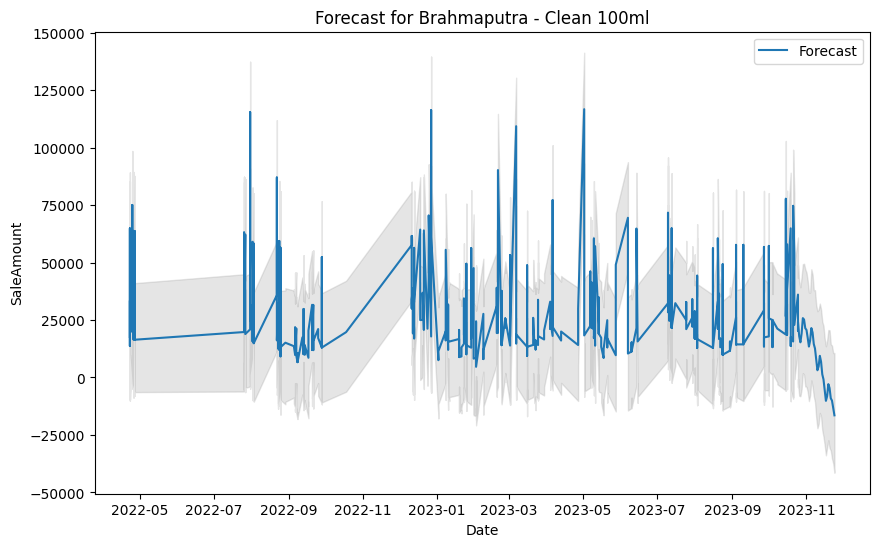

In [39]:
# Example of plotting the forecast for a specific Location and ItemName
pipeline.named_steps['prophet'].plot_forecast(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

In [58]:
pipeline.named_steps['prophet'].transform(forecast_df, location='Brahmaputra', item_name='Clean 100ml')

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,1.548354e+07,1.553218e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,1.548287e+07,1.553127e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,1.548339e+07,1.552945e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,1.548334e+07,1.552901e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,1.548423e+07,1.553151e+07,12854.142800,12854.142800,1.549416e+07,1.549416e+07,1.549416e+07,1.549332e+07,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,1.550701e+07,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,2023-11-20,13722.354027,-2.787062e+04,1.986805e+04,13722.353885,13722.354150,-1.831052e+04,-1.831052e+04,-1.831052e+04,0.000000e+00,...,4166.355702,-22476.876168,-22476.876168,-22476.876168,0.0,0.0,0.0,-4.588166e+03,Brahmaputra,Clean 100ml
762,2023-11-21,13723.861322,-3.293523e+04,1.745298e+04,13723.861170,13723.861453,-2.278043e+04,-2.278043e+04,-2.278043e+04,0.000000e+00,...,630.539009,-23410.969204,-23410.969204,-23410.969204,0.0,0.0,0.0,-9.056569e+03,Brahmaputra,Clean 100ml
763,2023-11-22,13725.368617,-3.521944e+04,1.343407e+04,13725.368456,13725.368760,-2.377313e+04,-2.377313e+04,-2.377313e+04,0.000000e+00,...,327.662121,-24100.793794,-24100.793794,-24100.793794,0.0,0.0,0.0,-1.004776e+04,Brahmaputra,Clean 100ml
764,2023-11-23,13726.875911,-3.822350e+04,9.902757e+03,13726.875742,13726.876064,-2.701495e+04,-2.701495e+04,-2.701495e+04,0.000000e+00,...,-2481.590224,-24533.363857,-24533.363857,-24533.363857,0.0,0.0,0.0,-1.328808e+04,Brahmaputra,Clean 100ml


In [42]:
# Example of generating and displaying weekly forecast
weekly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='weekly')
weekly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6600.226385,42040.987411,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,9546.689304,58076.809319,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-9372.022824,37558.850488,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,41372.144399,89451.135858,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36078.031928,86082.474262,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9658,2024-04-21,15541.120869,-15074.319134,36608.295683,15541.108858,15541.132982,-5749.511190,-5749.511190,-5749.511190,0.000,...,-2038.036593,-3711.474597,-3711.474597,-3711.474597,0.0,0.0,0.0,9791.609679,Turag,Clean 100ml
9659,2024-04-28,15455.303721,-17448.597855,32061.686882,15455.291094,15455.316647,-7048.085296,-7048.085296,-7048.085296,0.000,...,-2038.036593,-5010.048703,-5010.048703,-5010.048703,0.0,0.0,0.0,8407.218425,Turag,Clean 100ml
9660,2024-05-05,15369.486573,-22501.706142,29008.706672,15369.473406,15369.500250,-12438.969160,-12438.969160,-12438.969160,0.000,...,-2038.036593,-10400.932567,-10400.932567,-10400.932567,0.0,0.0,0.0,2930.517413,Turag,Clean 100ml
9661,2024-05-12,15283.669426,-29987.193787,18531.385825,15283.655643,15283.683844,-21206.091228,-21206.091228,-21206.091228,0.000,...,-2038.036593,-19168.054635,-19168.054635,-19168.054635,0.0,0.0,0.0,-5922.421802,Turag,Clean 100ml


In [43]:
# Example of generating and displaying monthly forecast
monthly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='monthly')
monthly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-7148.616972,42583.331380,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8467.321005,57831.396081,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-10319.819039,38268.689167,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,40639.276242,88824.434838,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36064.085334,85152.226667,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921,2025-11-30,8332.480457,-44952.005590,4430.782805,8332.383958,8332.571256,-28415.089372,-28415.089372,-28415.089372,0.000,...,-2038.036593,-26377.052779,-26377.052779,-26377.052779,0.0,0.0,0.0,-20082.608916,Turag,Clean 100ml
8922,2025-12-31,7952.433088,-14576.063202,40421.934503,7952.332222,7952.528744,2698.103334,2698.103334,2698.103334,0.000,...,-77.029606,2775.132940,2775.132940,2775.132940,0.0,0.0,0.0,10650.536422,Turag,Clean 100ml
8923,2026-01-31,7572.385719,-28348.150581,23972.890689,7572.279228,7572.487840,-9054.768713,-9054.768713,-9054.768713,0.000,...,-3434.972866,-5619.795847,-5619.795847,-5619.795847,0.0,0.0,0.0,-1482.382994,Turag,Clean 100ml
8924,2026-02-28,7229.117128,3293.304352,53436.403594,7229.004417,7229.225380,20463.762118,20463.762118,20463.762118,0.000,...,-3434.972866,23898.734984,23898.734984,23898.734984,0.0,0.0,0.0,27692.879247,Turag,Clean 100ml


In [45]:
# Example of generating and displaying half-yearly forecast
half_yearly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='half-yearly')
half_yearly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-6545.727237,39046.848980,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,10005.525991,57841.240305,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-10926.090479,37841.626513,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,39521.271230,89333.496513,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,33529.378316,85598.051167,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8735,2036-04-30,-38303.009558,-70984.497590,-19007.148728,-38303.572284,-38302.428473,-6129.389672,-6129.389672,-6129.389672,0.000,...,-77.029606,-6052.360067,-6052.360067,-6052.360067,0.0,0.0,0.0,-44432.399230,Turag,Clean 100ml
8736,2036-10-31,-40558.774585,-5829.825926,44513.636090,-40559.363361,-40558.158227,59823.738609,59823.738609,59823.738609,0.000,...,-2778.751462,62602.490071,62602.490071,62602.490071,0.0,0.0,0.0,19264.964025,Turag,Clean 100ml
8737,2037-04-30,-42777.760834,-82821.241740,-31799.485078,-42778.383684,-42777.112746,-14043.693338,-14043.693338,-14043.693338,0.000,...,-8142.874080,-5900.819258,-5900.819258,-5900.819258,0.0,0.0,0.0,-56821.454172,Turag,Clean 100ml
8738,2037-10-31,-45033.525861,-12818.586174,38873.398723,-45034.184270,-45032.842032,58752.086151,58752.086151,58752.086151,0.000,...,-3434.972865,62187.059017,62187.059017,62187.059017,0.0,0.0,0.0,13718.560290,Turag,Clean 100ml


In [46]:
# Example of generating and displaying yearly forecast
yearly_forecast_df = pipeline.named_steps['prophet'].transform(df, interval='yearly')
yearly_forecast_df

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,bonus_qty,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
0,2022-04-23,12854.142800,-5743.440393,40976.114730,12854.142800,12854.142800,4769.398365,4769.398365,4769.398365,3936.156,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,17623.541165,Brahmaputra,Clean 100ml
1,2022-04-23,12854.142800,8358.319798,57352.957715,12854.142800,12854.142800,20514.022365,20514.022365,20514.022365,19680.780,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,33368.165165,Brahmaputra,Clean 100ml
2,2022-04-23,12854.142800,-11326.213439,38625.119314,12854.142800,12854.142800,833.242365,833.242365,833.242365,0.000,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,13687.385165,Brahmaputra,Clean 100ml
3,2022-04-23,12854.142800,41538.918228,88061.017627,12854.142800,12854.142800,52003.270365,52003.270365,52003.270365,51170.028,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,64857.413165,Brahmaputra,Clean 100ml
4,2022-04-23,12854.142800,36624.403727,84860.240638,12854.142800,12854.142800,48067.114365,48067.114365,48067.114365,47233.872,...,-1869.843955,2703.086320,2703.086320,2703.086320,0.0,0.0,0.0,60921.257165,Brahmaputra,Clean 100ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8692,2048-12-31,-95040.403823,-124920.000393,-73875.968739,-95041.554272,-95039.402389,-5397.220583,-5397.220583,-5397.220583,0.000,...,-8142.874080,2745.653497,2745.653497,2745.653497,0.0,0.0,0.0,-100437.624406,Turag,Clean 100ml
8693,2049-12-31,-99515.155099,-124260.034278,-73929.080634,-99516.385136,-99514.103443,-3.618522,-3.618522,-3.618522,0.000,...,-2778.751462,2775.132940,2775.132940,2775.132940,0.0,0.0,0.0,-99518.773621,Turag,Clean 100ml
8694,2050-12-31,-103989.906376,-129273.106032,-81764.797011,-103991.194389,-103988.791013,-630.604409,-630.604409,-630.604409,0.000,...,-3434.972865,2804.368457,2804.368457,2804.368457,0.0,0.0,0.0,-104620.510784,Turag,Clean 100ml
8695,2051-12-31,-108464.657652,-134404.321850,-83038.180388,-108466.008628,-108463.487640,795.191488,795.191488,795.191488,0.000,...,-2038.036593,2833.228081,2833.228081,2833.228081,0.0,0.0,0.0,-107669.466164,Turag,Clean 100ml


In [ ]:
# Aggregate predictions on a weekly basis
weekly_predictions = forecast.resample('W-Mon', on='ds').sum()
weekly_predictions

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
ds,,,,,,,,,,,,,,,,,,,,
2022-04-25,7.157403e+05,-6.662601e+04,1.566541e+06,7.157403e+05,7.157403e+05,3.120782e+04,3.120782e+04,3.120782e+04,17883.467599,17883.467599,17883.467599,1.332435e+04,1.332435e+04,1.332435e+04,0.0,0.0,0.0,7.469481e+05,TuragBrahmaputraGumtiKaratoaKarnaphuliPadmaTur...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2022-05-02,4.685378e+05,-1.182485e+05,1.043640e+06,4.685378e+05,4.685378e+05,-4.994123e+03,-4.994123e+03,-4.994123e+03,-7415.212787,-7415.212787,-7415.212787,2.421089e+03,2.421089e+03,2.421089e+03,0.0,0.0,0.0,4.635437e+05,BrahmaputraGumtiKirtonkholaKopotakkhoMuhuriPad...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2022-05-09,2.537853e+05,-1.759314e+05,3.806579e+05,2.537853e+05,2.537853e+05,-1.542471e+05,-1.542471e+05,-1.542471e+05,19833.010302,19833.010302,19833.010302,-1.740801e+05,-1.740801e+05,-1.740801e+05,0.0,0.0,0.0,9.953827e+04,GumtiKopotakkhoPadmaRupshaKaratoaPadmaRupshaSurma,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2022-05-16,4.987385e+05,-1.849193e+05,6.571331e+05,4.987385e+05,4.987385e+05,-2.648634e+05,-2.648634e+05,-2.648634e+05,23174.772219,23174.772219,23174.772219,-2.880382e+05,-2.880382e+05,-2.880382e+05,0.0,0.0,0.0,2.338751e+05,KarnaphuliKopotakkhoPadmaTistaKopotakkhoPadmaT...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2022-05-23,2.359561e+05,-8.874064e+04,5.765315e+05,2.359561e+05,2.359561e+05,8.232355e+03,8.232355e+03,8.232355e+03,138317.899056,138317.899056,138317.899056,-1.300855e+05,-1.300855e+05,-1.300855e+05,0.0,0.0,0.0,2.441885e+05,KopotakkhoMuhuriKopotakkhoPadmaMuhuriKaratoaKo...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,1.373904e+07,5.479143e+06,1.267563e+07,1.308638e+07,1.446212e+07,-4.699470e+06,-4.699470e+06,-4.699470e+06,-10108.790611,-10108.790611,-10108.790611,-4.689361e+06,-4.689361e+06,-4.689361e+06,0.0,0.0,0.0,9.039573e+06,BrahmaputraCorporateGumtiKaratoaKarnaphuliKopo...,Clean 100mlGentech - P.S (20 LTr.)Clean 100mlC...
2024-10-07,8.072572e+06,1.953629e+06,8.088185e+06,7.784997e+06,8.387214e+06,-3.065666e+06,-3.065666e+06,-3.065666e+06,391251.960643,391251.960643,391251.960643,-3.456918e+06,-3.456918e+06,-3.456918e+06,0.0,0.0,0.0,5.006906e+06,BrahmaputraCorporateGumtiKaratoaKarnaphuliKopo...,Clean 100mlGentech - P.S (20 LTr.)Clean 100mlC...
2024-10-14,4.068515e+06,-3.470897e+05,5.169850e+06,4.068270e+06,4.068757e+06,-1.653824e+06,-1.653824e+06,-1.653824e+06,7861.034984,7861.034984,7861.034984,-1.661685e+06,-1.661685e+06,-1.661685e+06,0.0,0.0,0.0,2.414691e+06,BrahmaputraGumtiKaratoaKopotakkhoMuhuriPadmaRu...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...


In [ ]:
# Aggregate predictions on a monthly basis
monthly_predictions = forecast.resample('M', on='ds').sum()
monthly_predictions

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
ds,,,,,,,,,,,,,,,,,,,,
2022-04-30,1.184278e+06,-1.848745e+05,2.610182e+06,1.184278e+06,1.184278e+06,2.621369e+04,2.621369e+04,2.621369e+04,1.046825e+04,1.046825e+04,1.046825e+04,1.574544e+04,1.574544e+04,1.574544e+04,0.0,0.0,0.0,1.210492e+06,TuragBrahmaputraGumtiKaratoaKarnaphuliPadmaTur...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2022-05-31,1.187479e+06,-5.813810e+05,1.996492e+06,1.187479e+06,1.187479e+06,-4.840839e+05,-4.840839e+05,-4.840839e+05,1.744287e+05,1.744287e+05,1.744287e+05,-6.585126e+05,-6.585126e+05,-6.585126e+05,0.0,0.0,0.0,7.033948e+05,GumtiKopotakkhoPadmaRupshaKaratoaPadmaRupshaSu...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2022-06-30,4.702775e+05,-1.687462e+05,9.239383e+05,4.702775e+05,4.702775e+05,-9.537583e+04,-9.537583e+04,-9.537583e+04,-6.175485e+04,-6.175485e+04,-6.175485e+04,-3.362097e+04,-3.362097e+04,-3.362097e+04,0.0,0.0,0.0,3.749017e+05,KopotakkhoKopotakkhoTuragKirtonkholaKaratoaKir...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2022-07-31,-8.348979e+06,-7.806133e+06,-4.840531e+06,-8.348979e+06,-8.348979e+06,2.022718e+06,2.022718e+06,2.022718e+06,1.997269e+05,1.997269e+05,1.997269e+05,1.822991e+06,1.822991e+06,1.822991e+06,0.0,0.0,0.0,-6.326261e+06,KaratoaKaratoaKaratoaKaratoaKopotakkhoKaratoaK...,Fresmin F 10kgFresmin F 10kgFresmin F 10kgFres...
2022-08-31,-2.100528e+07,-2.661543e+07,-2.026747e+07,-2.100528e+07,-2.100527e+07,-2.432565e+06,-2.432565e+06,-2.432565e+06,-2.327572e+05,-2.327572e+05,-2.327572e+05,-2.199807e+06,-2.199807e+06,-2.199807e+06,0.0,0.0,0.0,-2.343784e+07,GumtiKaratoaMuhuriRupshaTuragBrahmaputraGumtiK...,Clean 100mlFresmin F 10kgViusid Vet 500mlClean...
2022-09-30,-3.369859e+07,-2.619864e+07,-2.105349e+07,-3.369859e+07,-3.369859e+07,1.005835e+07,1.005835e+07,1.005835e+07,4.686548e+05,4.686548e+05,4.686548e+05,9.589691e+06,9.589691e+06,9.589691e+06,0.0,0.0,0.0,-2.364024e+07,KaratoaKaratoaKarnaphuliKirtonkholaKopotakkhoM...,Clean 100mlFresmin F 10kgClean 100mlClean 100m...
2022-10-31,-4.869551e+07,-5.579495e+07,-5.202846e+07,-4.869551e+07,-4.869551e+07,-5.204658e+06,-5.204658e+06,-5.204658e+06,4.348860e+05,4.348860e+05,4.348860e+05,-5.639544e+06,-5.639544e+06,-5.639544e+06,0.0,0.0,0.0,-5.390017e+07,KaratoaMuhuriTuragKaratoaKaratoaKopotakkhoMuhu...,Fresmin F 10kgViusid Vet 500mlClean 100mlClean...
2022-11-30,-6.072807e+07,-7.237198e+07,-6.528070e+07,-6.072808e+07,-6.072807e+07,-8.097586e+06,-8.097586e+06,-8.097586e+06,-2.256594e+05,-2.256594e+05,-2.256594e+05,-7.871927e+06,-7.871927e+06,-7.871927e+06,0.0,0.0,0.0,-6.882566e+07,BrahmaputraGumtiKaratoaKaratoaKopotakkhoMuhuri...,Fresmin F 10kgClean 100mlClean 100mlFresmin F ...
2022-12-31,-7.449534e+07,-6.622838e+07,-5.628369e+07,-7.449535e+07,-7.449534e+07,1.324463e+07,1.324463e+07,1.324463e+07,3.997392e+04,3.997392e+04,3.997392e+04,1.320465e+07,1.320465e+07,1.320465e+07,0.0,0.0,0.0,-6.125071e+07,BrahmaputraKaratoaKirtonkholaKopotakkhoMuhuriB...,Fresmin F 10kgFresmin F 10kgClean 100mlFresmin...


In [ ]:
# Aggregate predictions on a half_yearly basis
half_yearly_predictions = forecast.resample('6M', on='ds').sum()
half_yearly_predictions

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
ds,,,,,,,,,,,,,,,,,,,,
2022-04-30,1.184278e+06,-1.848745e+05,2.610182e+06,1.184278e+06,1.184278e+06,2.621369e+04,2.621369e+04,2.621369e+04,1.046825e+04,1.046825e+04,1.046825e+04,1.574544e+04,1.574544e+04,1.574544e+04,0.0,0.0,0.0,1.210492e+06,TuragBrahmaputraGumtiKaratoaKarnaphuliPadmaTur...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2022-10-31,-1.100906e+08,-1.171653e+08,-9.526952e+07,-1.100906e+08,-1.100906e+08,3.864381e+06,3.864381e+06,3.864381e+06,9.831844e+05,9.831844e+05,9.831844e+05,2.881196e+06,2.881196e+06,2.881196e+06,0.0,0.0,0.0,-1.062262e+08,GumtiKopotakkhoPadmaRupshaKaratoaPadmaRupshaSu...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2023-04-30,-5.552538e+08,-5.972569e+08,-5.373896e+08,-5.552538e+08,-5.552537e+08,-1.209451e+07,-1.209451e+07,-1.209451e+07,9.610947e+05,9.610947e+05,9.610947e+05,-1.305561e+07,-1.305561e+07,-1.305561e+07,0.0,0.0,0.0,-5.673483e+08,BrahmaputraGumtiKaratoaKaratoaKopotakkhoMuhuri...,Fresmin F 10kgClean 100mlClean 100mlFresmin F ...
2023-10-31,-4.812326e+08,-5.335890e+08,-4.505879e+08,-4.812340e+08,-4.812302e+08,-1.081879e+07,-1.081879e+07,-1.081879e+07,2.693235e+06,2.693235e+06,2.693235e+06,-1.351203e+07,-1.351203e+07,-1.351203e+07,0.0,0.0,0.0,-4.920514e+08,BrahmaputraKaratoaKaratoaKirtonkholaKopotakkho...,Fresmin F 10kgVivabond (5Ltr.)Fresmin F 10kgCl...
2024-04-30,-1.140399e+08,-1.817456e+08,-1.995889e+06,-1.170176e+08,-1.105657e+08,2.193684e+07,2.193684e+07,2.193684e+07,8.650619e+04,8.650619e+04,8.650619e+04,2.185034e+07,2.185034e+07,2.185034e+07,0.0,0.0,0.0,-9.210311e+07,BrahmaputraCorporateCorporateCorporateCorporat...,Clean 100mlGentech - P.S (20 LTr.)Clean 100mlV...
2024-10-31,3.097674e+08,2.165051e+08,3.918650e+08,2.991608e+08,3.213377e+08,-6.093295e+06,-6.093295e+06,-6.093295e+06,-3.512288e+05,-3.512288e+05,-3.512288e+05,-5.742066e+06,-5.742066e+06,-5.742066e+06,0.0,0.0,0.0,3.036741e+08,BrahmaputraCorporateCorporateCorporateCorporat...,Clean 100mlGentech - P.S (20 LTr.)Clean 100mlV...


In [ ]:
yearly_predictions = forecast.resample('Y', on='ds').sum()
yearly_predictions

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Location,ItemName
ds,,,,,,,,,,,,,,,,,,,,
2022-12-31,-2.441297e+08,-2.559505e+08,-2.142237e+08,-2.441297e+08,-2.441297e+08,9.037636e+06,9.037636e+06,9.037636e+06,8.079672e+05,8.079672e+05,8.079672e+05,8.229669e+06,8.229669e+06,8.229669e+06,0.0,0.0,0.0,-2.350921e+08,TuragBrahmaputraGumtiKaratoaKarnaphuliPadmaTur...,Clean 100mlClean 100mlClean 100mlClean 100mlCl...
2023-12-31,-9.525462e+08,-9.311937e+08,-7.463921e+08,-9.527611e+08,-9.522753e+08,1.136885e+08,1.136885e+08,1.136885e+08,1.634300e+06,1.634300e+06,1.634300e+06,1.120542e+08,1.120542e+08,1.120542e+08,0.0,0.0,0.0,-8.388576e+08,BrahmaputraGumtiKaratoaKirtonkholaKopotakkhoKo...,Fresmin F 10kgClean 100mlFresmin F 10kgClean 1...
2024-12-31,2.470107e+08,-2.629240e+07,2.698480e+08,2.336399e+08,2.617868e+08,-1.259053e+08,-1.259053e+08,-1.259053e+08,1.940992e+06,1.940992e+06,1.940992e+06,-1.278463e+08,-1.278463e+08,-1.278463e+08,0.0,0.0,0.0,1.211053e+08,BrahmaputraCorporateCorporateCorporateCorporat...,Clean 100mlGentech - P.S (20 LTr.)Clean 100mlV...
